## Makemore pt.3 - building a language model to generate names (improved activations)

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random
import math
from dataclasses import dataclass
from typing import List

In [2]:
data_set_words = open('./names.txt').read().splitlines()
print(f'{len(data_set_words)} words in the training set')

32033 words in the training set


In [3]:
## MLP revisited - reusing the code from notebook #2

# Build mappings from chars to integers
data_space = set([char for word in data_set_words for char in list(word)])
stoi = {ch : i+1 for i, ch in enumerate(sorted(data_space))}
stoi['.'] = 0
itos = {i : ch for ch, i in stoi.items()}

# RNG
generator = torch.Generator().manual_seed(2147483647)

@dataclass
class HyperParameters:
    context_size: int = 3 # How many characters of context should NN get to make a prediction?
    embedding_dims: int = 5 # How many dimensions embedding vectors have?
    hidden_layer_size: int = 250 # How many neurons in the hidden layer?

class Parameters:
    def __init__(self, g: torch.Generator, hp: HyperParameters):
        hidden_layer_inputs = hp.context_size * hp.embedding_dims
        self.C = torch.randn((27, hp.embedding_dims), generator=g, requires_grad=True)
        self.W1 = torch.randn((hidden_layer_inputs, hp.hidden_layer_size), generator=g, requires_grad=True) # hidden layer weigths
        self.b1 = torch.randn((hp.hidden_layer_size), generator=g, requires_grad=True) # hidden layer biases
        self.W2 = torch.randn((hp.hidden_layer_size, 27), generator=g, requires_grad=True) # out layer weigths
        self.b2 = torch.randn((27), generator=g, requires_grad=True) # out layer biases
    
    def all(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    def zero_grad(self):
        for param in self.all():
            param.grad = None
    
    def update(self, learning_rate):
        for param in self.all():
            param.data += -learning_rate * param.grad

@dataclass 
class TrainingData:
    x_train: torch.Tensor
    y_train: torch.Tensor
    x_val: torch.Tensor
    y_val: torch.Tensor
    x_test: torch.Tensor
    y_test: torch.Tensor

class TrainingDataBuilder:
    @staticmethod
    def build(data_space, hp: HyperParameters):
        random.shuffle(data_space) # modifies the input data
        size = len(data_space)
        c_z = hp.context_size
        # 80% training, 10% validation, 10% testing data split
        x_train, y_train = TrainingDataBuilder._bulid_dataset(data_space[:int(0.8*size)], context_size=c_z)
        x_val, y_val = TrainingDataBuilder._bulid_dataset(data_space[int(0.8*size):int(0.9*size)], context_size=c_z)
        x_test, y_test = TrainingDataBuilder._bulid_dataset(data_space[int(0.9*size):], context_size=c_z)
        return TrainingData(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test)

    @staticmethod
    # Construct training data set - consecutive <context_size> characters x and the next character y
    def _bulid_dataset(input, context_size, debug=False):
        x, y = [], []
        for word in input:
            if debug: print(f'word: {word}')
            # Initialize the rolling context window to all 0 characters ('.')
            context = [stoi['.']] * context_size
            for ch in list(word) + ['.']:
                idx = stoi[ch]
                x.append(context)
                y.append(idx)
                if debug: print(''.join([itos[c] for c in context]) + " -> " + itos[idx])
                context = context[1:] + [idx]
        x = torch.tensor(x)
        y = torch.tensor(y)
        return x, y
    
def get_loss(x_data, y_data, params: Parameters, hp: HyperParameters):
    # Forward
    input_size = hp.context_size * hp.embedding_dims
    embeddings = params.C[x_data].view((-1, input_size))
    hidden = torch.tanh(embeddings @ params.W1 + params.b1)
    out = hidden @ params.W2 + params.b2
    # Calculate loss
    return F.cross_entropy(out, y_data)

def get_learning_rate(i):
    return 0.1 if i < 50000 else 0.01 if i < 100000 else 0.001

def train_nn(iters: int, data: TrainingData, params: Parameters, hp: HyperParameters, batch_size: int = 64):
    plot_data = torch.zeros((iters, 2))
    for i in range(iters):
        # Prepare batch
        batch_i = torch.randint(0, data.x_train.shape[0], (batch_size,))
        x_batch = data.x_train[batch_i]
        y_batch = data.y_train[batch_i]
        # Forward + calculate loss
        loss = get_loss(x_batch, y_batch, params, hp)
        if i % 10000 == 0: print(f'iteration {i}/{iters}, loss:{loss.item()}')
        plot_data[i] = torch.tensor([i, loss.item()])
        params.zero_grad()
        # Backward
        loss.backward()
        # Update
        params.update(get_learning_rate(i))
    return plot_data

def sample_network(iters: int, params: Parameters, hp: HyperParameters):
    words = []
    for _ in range(iters):
        context = [stoi['.']] * hp.context_size
        word = ''
        while True:
            # Forward
            embeddings = params.C[torch.tensor([context])]
            hidden = torch.tanh(embeddings.view(1, -1) @ params.W1 + params.b1)
            out = hidden @ params.W2 + params.b2
            probs = torch.softmax(out, dim=1)
            # Sample with distribution from probs
            sampled_idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
            if sampled_idx == 0: break
            # Move the context window
            context = context[1:] + [sampled_idx]
            word += itos[int(sampled_idx)]
        words.append(word)
    return words


In [4]:
hyper_params = HyperParameters(context_size=4, embedding_dims=10, hidden_layer_size=256)
params = Parameters(g=generator, hp=hyper_params)
data = TrainingDataBuilder.build(data_space=data_set_words, hp=hyper_params)

iteration 0/150000, loss:30.71477699279785
iteration 10000/150000, loss:3.0772767066955566
iteration 20000/150000, loss:2.437168598175049
iteration 30000/150000, loss:2.5242273807525635
iteration 40000/150000, loss:2.608099937438965
iteration 50000/150000, loss:2.3387060165405273
iteration 60000/150000, loss:2.142577886581421
iteration 70000/150000, loss:2.706998109817505
iteration 80000/150000, loss:2.2130987644195557
iteration 90000/150000, loss:1.887441873550415
iteration 100000/150000, loss:2.12693190574646
iteration 110000/150000, loss:2.5967960357666016
iteration 120000/150000, loss:1.9184190034866333
iteration 130000/150000, loss:2.3600049018859863
iteration 140000/150000, loss:2.3997116088867188
loss on validation set: 2.230970621109009


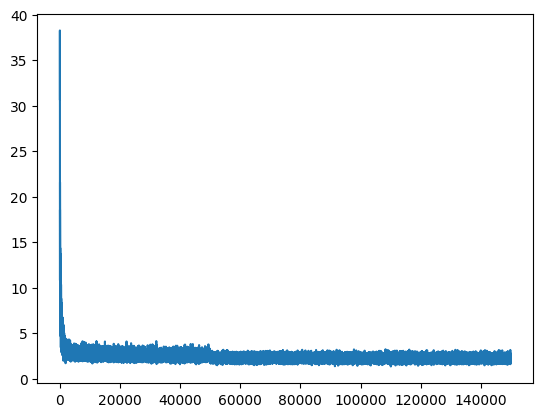

In [5]:
loss_data = train_nn(150000, data, params, hyper_params, batch_size=32)
plt.plot(loss_data[:, 0], loss_data[:, 1])
print(f'loss on validation set: {get_loss(data.x_val, data.y_val, params, hyper_params).item()}')

In [6]:
sample_network(10, params, hyper_params)

['dankla',
 'brai',
 'kaie',
 'ane',
 'fisn',
 'andee',
 'zevoa',
 'idhlyn',
 'mualy',
 'vine']

## Problems with the approach from MLP solution
### Problem \#1 - the initial loss is too high
We are starting from ~30 loss on the first iteration. This causes a sharp drop on the loss over iteration no. plot.  
Loss 30 is much higher than a model that e.g. thinks that all characters are equally likely - it's ~3.3 loss.

**Fixes**  
Make the output layer more uniform - have the initial values closer to zero.
- make B2 zeroes - don't add values from normal distribution to NN output, unnecessarily increasing it and increasing the variation in the network output.
- multiply W2 by a factor of 0.01, so that they are closer to zero, but stil has some entropy.

In [7]:
print(f'loss of 30 is a probabilty prob={math.e ** -30}, uniform distribution among all 27 chars is loss={-math.log(1/27):.4f} and prob={1/27:.4f}')

loss of 30 is a probabilty prob=9.35762296884019e-14, uniform distribution among all 27 chars is loss=3.2958 and prob=0.0370


In [8]:
# Reimplement the parameters class
class BetterParameters(Parameters):
    def __init__(self, g: torch.Generator, hp: HyperParameters):
        hidden_layer_inputs = hp.context_size * hp.embedding_dims
        self.C = torch.randn((27, hp.embedding_dims), generator=g)
        self.W1 = torch.randn((hidden_layer_inputs, hp.hidden_layer_size), generator=g) # hidden layer weigths
        self.b1 = torch.randn((hp.hidden_layer_size), generator=g) # hidden layer biases
        self.W2 = torch.randn((hp.hidden_layer_size, 27), generator=g) * 0.01 # out layer weigths
        self.b2 = torch.randn((27), generator=g) * 0 # out layer biases
        for param in self.all():
            param.requires_grad = True
    
    def all(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    def zero_grad(self):
        for param in self.all():
            param.grad = None
    
    def update(self, learning_rate):
        for param in self.all():
            param.data += -learning_rate * param.grad

iteration 0/250000, loss:3.279601812362671
iteration 10000/250000, loss:2.522857189178467
iteration 20000/250000, loss:2.0491597652435303
iteration 30000/250000, loss:2.2056195735931396
iteration 40000/250000, loss:2.489373207092285
iteration 50000/250000, loss:2.2152516841888428
iteration 60000/250000, loss:1.7685490846633911
iteration 70000/250000, loss:1.7593084573745728
iteration 80000/250000, loss:2.293757915496826
iteration 90000/250000, loss:2.3435773849487305
iteration 100000/250000, loss:2.295271396636963
iteration 110000/250000, loss:1.8640774488449097
iteration 120000/250000, loss:2.0222456455230713
iteration 130000/250000, loss:2.164247512817383
iteration 140000/250000, loss:2.071420431137085
iteration 150000/250000, loss:1.9207260608673096
iteration 160000/250000, loss:1.670093297958374
iteration 170000/250000, loss:1.9181793928146362
iteration 180000/250000, loss:2.3286983966827393
iteration 190000/250000, loss:2.1886885166168213
iteration 200000/250000, loss:1.8553128242

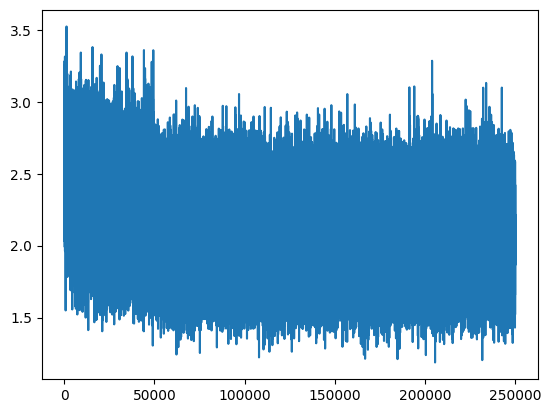

In [9]:
hyper_params = HyperParameters(context_size=4, embedding_dims=10, hidden_layer_size=256)
data = TrainingDataBuilder.build(data_space=data_set_words, hp=hyper_params)
bparams = BetterParameters(generator, hyper_params)

loss_data = train_nn(250000, data, bparams, hyper_params, batch_size=32)
print(f'loss on validation set: {get_loss(data.x_val, data.y_val, bparams, hyper_params).item()}')
plt.plot(loss_data[:, 0], loss_data[:, 1])

## Problem \#2 - Distribution of hidden layer output - tanh

Almost all of the activations in the hidden layer are in the "tail" values - -1 or +1.

Because tanh gradient is `1 - tanh**2`, this essentially makes the gradient "0". This kills the propagation of the loss gradient backward, to the embeddings and W1/b1.

Standard deviation of the preactivations: 5.039653301239014


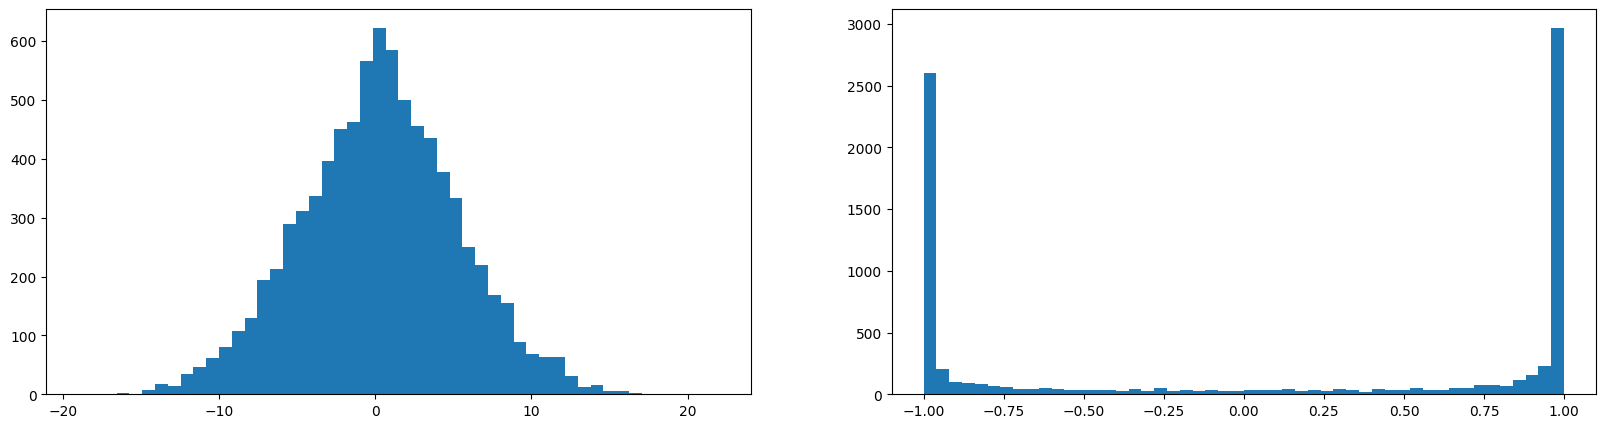

In [10]:
h_input_size = hyper_params.context_size * hyper_params.embedding_dims
embeds = bparams.C[data.x_train[:32]]

preactivations = embeds.view(-1, h_input_size) @ bparams.W1 + bparams.b1
h = torch.tanh(preactivations)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(preactivations.view(-1).tolist(), 50)
plt.subplot(122)
plt.hist(h.view(-1).tolist(), 50)
print(f'Standard deviation of the preactivations: {preactivations.std()}')

### Visualizing neurons that "never learn"
As can be seen on the diagrams above, the function fed into the tanh has a wide distribution. Do to how tanh works, this makes vast majority of the values get "squashed" as either 1 or -1, and destroy the gradient.

The diagram below shows in white the neurons that destroy the gradients (abs value > 0.99) for each training examples.

Dead neurons: []


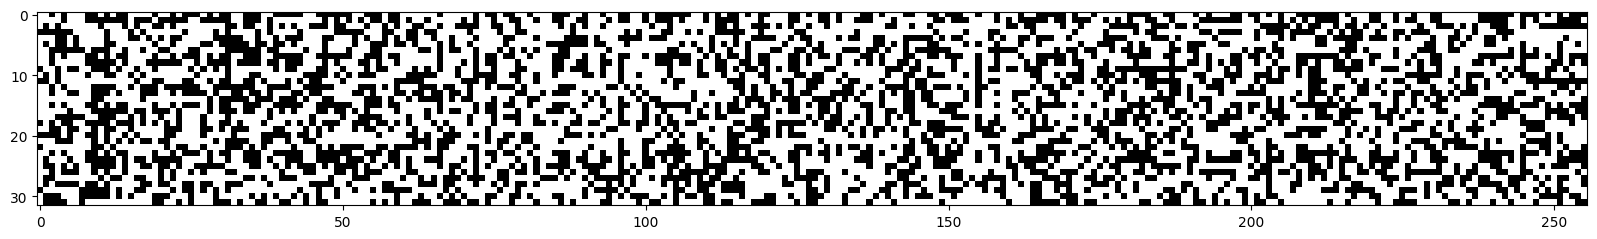

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray')

neurons_ct = [0] * hyper_params.hidden_layer_size
for row in h:
    for i, v in enumerate(row):
        if v.abs() <= 0.99: neurons_ct[i] += 1
print(f'Dead neurons: {[i for i, e in enumerate(neurons_ct) if e == 0]}')

### Dead neurons
It can happen than when the learning rate is too large, the neuron changes weights and bias in too extreme way, and it can be "knocked off". It's then put it into a state that makes it never activate for any input. Like a brain damage for NN.

### Fixing the problem - NN initialization
We need a way to keep the tanh (and other non-linearities) in the healthy bounds. This can be thought of as scaling the gaussian distribution of the preactive values - keeping the distribution plotted on the left side above slim, with std deviation = 1, and mean = 0 so that they are Gaussian.

Turns out the science around this has been worked out, and there is a formula for each non-linearity. Formula: gain / sqrt(fan-in) 
(fan-in = number of input elements)

Paper for reference: `Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)`

This is implemented as "Kaiming init" in Pytorch, in `torch.nn.init.calculate_gain(nonlinearity, param)`

input.std()=tensor(0.9872), out.std()=tensor(1.0155)


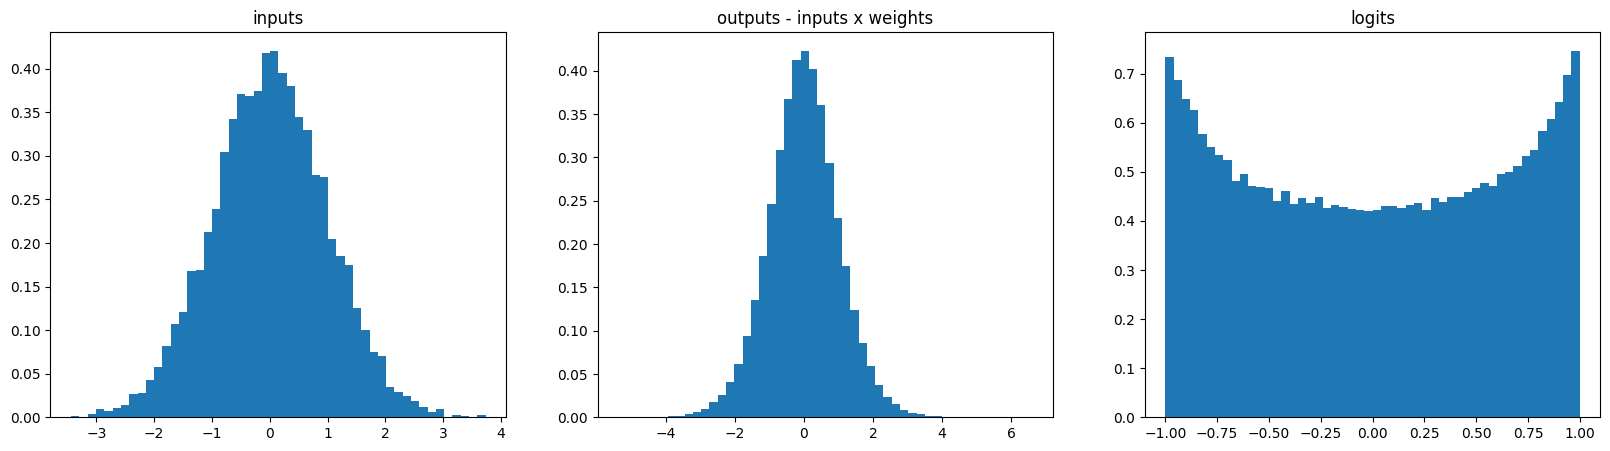

In [12]:
input = torch.randn(1000, 10)
w = torch.randn(10, 200)
# Scale the weights with Kaiming init - divide by square root of fan-in
w /= w.shape[0]**0.5
out = input @ w
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title("inputs")
plt.hist(input.view(-1).tolist(), 50, density=True)
plt.subplot(132)
plt.title("outputs - inputs x weights")
plt.hist(out.view(-1).tolist(), 50, density=True)
plt.subplot(133)
plt.title("logits")
plt.hist(torch.tanh(out.view(-1)).tolist(), 50, density=True)
print(f'{input.std()=}, {out.std()=}')

In [13]:
# Reimplement the parameters class
class ParametersWithKaimingInit(Parameters):
    def __init__(self, g: torch.Generator, hp: HyperParameters):
        hidden_layer_inputs = hp.context_size * hp.embedding_dims
        kaiming_init_factor = (5/3) / hidden_layer_inputs**0.5 # 5/3 - gain for tanh
        self.C = torch.randn((27, hp.embedding_dims), generator=g)
        self.W1 = torch.randn((hidden_layer_inputs, hp.hidden_layer_size), generator=g) * kaiming_init_factor # hidden layer weigths
        self.b1 = torch.randn((hp.hidden_layer_size), generator=g) * 0.01 # hidden layer biases
        self.W2 = torch.randn((hp.hidden_layer_size, 27), generator=g) * 0.01 # out layer weigths
        self.b2 = torch.randn((27), generator=g) * 0 # out layer biases
        for param in self.all():
            param.requires_grad = True
    
    def all(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    def zero_grad(self):
        for param in self.all():
            param.grad = None
    
    def update(self, learning_rate):
        for param in self.all():
            param.data += -learning_rate * param.grad

### How does modern ML handles this actually - batch normalization
Currently it's much easier and no so brittle actually. We can use the technique called 'batch normalization'

Paper: `Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift`

Again, we want the **preactivations** for NN to be in the sweet spot - so that the tanh (or other non-linearity) is not saturated, as it kills the gradient and hinders the ability of the NN to learn. We want them to be Gaussian - close to the normal distribution.

The insight from the paper is that - to do that, you can actually take the hidden states and... just normalize them to be Gaussian :) Quite unintuitively, we can do this and this will work.

![img](./batch_normalization_recipe.png)

The last step of scale and shift gives the flexibility for the normalized neuron weights to change the spread of the Gaussian distro (change std deviation), as well as move it around (change mean)

In [14]:
hidden_layer_inputs = hyper_params.context_size * hyper_params.embedding_dims
inputs = params.C[data.x_train[:1024]].view(-1, hidden_layer_inputs)
hidden_preact = inputs @ params.W1 + params.b1
print(f'preactivations {hidden_preact.mean(0, keepdim=True).shape=}, {hidden_preact.std(0, keepdim=True).shape=}')

preactivations hidden_preact.mean(0, keepdim=True).shape=torch.Size([1, 256]), hidden_preact.std(0, keepdim=True).shape=torch.Size([1, 256])


In [15]:
def get_loss(x_data, y_data, params: Parameters, hp: HyperParameters):
    # Forward
    input_size = hp.context_size * hp.embedding_dims
    embeddings = params.C[x_data].view((-1, input_size))
    hidden_preact = embeddings @ params.W1 + params.b1
    # Batch normalization. This makes the neuron weights for the current batch be Gaussian.
    hidden_preact = (hidden_preact - hidden_preact.mean(0, keepdim=True)) / hidden_preact.std(0, keepdim=True)
    hidden = torch.tanh(hidden_preact)
    out = hidden @ params.W2 + params.b2
    # Calculate loss
    return F.cross_entropy(out, y_data)

def train_nn_batch_norm(iters: int, data: TrainingData, params: Parameters, hp: HyperParameters, batch_size: int = 64):
    plot_data = torch.zeros((iters, 2))
    for i in range(iters):
        # Prepare batch
        batch_i = torch.randint(0, data.x_train.shape[0], (batch_size,))
        x_batch = data.x_train[batch_i]
        y_batch = data.y_train[batch_i]
        # Forward + calculate loss
        loss = get_loss(x_batch, y_batch, params, hp)
        if i % 10000 == 0: print(f'iteration {i}/{iters}, loss:{loss.item()}')
        plot_data[i] = torch.tensor([i, loss.item()])
        params.zero_grad()
        # Backward
        loss.backward()
        # Update
        params.update(get_learning_rate(i))
    return plot_data

### Problem with batch normalization

There is a certain imporant change before and after the batch normalization. Previously, the way we calculated preactivations and logits was independent - there was no coupling between the examples randomly selected for a batch rather than in the loss function. So there was coupling in the backward pass. But now we also have coupling in the forward pass.

There are other normalization techniques that do not introduce this coupling.

The other problem is that in forward pass our NN expects batches to calculate STD and mean, so how do we sample the model?

### Solution

Introduce rolling mean - calculate the mean and std on the fly while training the model, and use it later on for inference.

In [16]:
# Reimplement the parameters class again, this time using Batch Normalization
class ParametersWithBatchNorm(Parameters):
    def __init__(self, g: torch.Generator, hp: HyperParameters):
        hidden_layer_inputs = hp.context_size * hp.embedding_dims
        kaiming_init_factor = (5/3) / hidden_layer_inputs**0.5 # 5/3 - gain for tanh
        self.C = torch.randn((27, hp.embedding_dims), generator=g)
        self.W1 = torch.randn((hidden_layer_inputs, hp.hidden_layer_size), generator=g) * kaiming_init_factor # hidden layer weigths
        # B1 biases are basically useless now. We are subtracting the mean for hidden layer preactivations in the batchnorm layer anyway. The self.bn_bias does the shifting.
        # self.b1 = torch.randn((hp.hidden_layer_size), generator=g) * 0.01 # hidden layer biases
        self.W2 = torch.randn((hp.hidden_layer_size, 27), generator=g) * 0.01 # out layer weigths
        self.b2 = torch.randn((27), generator=g) * 0 # out layer biases

        # Scale the gaussian
        self.bn_gain = torch.ones(1, hp.hidden_layer_size)
        # ... and shift
        self.bn_bias = torch.zeros(1, hp.hidden_layer_size)
        # Calculate the running mean. Gaussian distribution has mean = 0
        self.bn_mean_running = torch.zeros(1, hp.hidden_layer_size)
        # Calculate the running std. Gaussian distribution has std = 1
        self.bn_std_running = torch.ones(1, hp.hidden_layer_size)
        for param in self.all():
            param.requires_grad = True
    
    def all(self):
        return [self.C, self.W1, self.W2, self.b2, self.bn_gain, self.bn_bias]
    
    def zero_grad(self):
        for param in self.all():
            param.grad = None
    
    def update(self, learning_rate):
        for param in self.all():
            param.data += -learning_rate * param.grad

In [17]:
# Reimplement training yet again - this time using all the Batch Norm tricks 
def get_loss_batch_norm_final(x_data, y_data, params: ParametersWithBatchNorm, hp: HyperParameters):
    # Forward
    input_size = hp.context_size * hp.embedding_dims
    embeddings = params.C[x_data].view((-1, input_size))
    hidden_preact = embeddings @ params.W1
    # Batch normalization. This makes the neuron weights for the current batch be Gaussian.
    bn_mean_i = hidden_preact.mean(0, keepdim=True)
    bn_std_i = hidden_preact.std(0, keepdim=True)
    hidden_preact = params.bn_gain * (hidden_preact - bn_mean_i) / bn_std_i + params.bn_bias

    # Calcuate the running means and stds. Could use the 1/training_set_size instead of 0.999 magic numbers here.
    with torch.no_grad():
        params.bn_mean_running = 0.999 * params.bn_mean_running + 0.001 * bn_mean_i
        params.bn_std_running = 0.999 * params.bn_std_running + 0.001 * bn_std_i
    
    hidden = torch.tanh(hidden_preact)
    out = hidden @ params.W2 + params.b2
    # Calculate loss
    return F.cross_entropy(out, y_data)

# Compared to train_nn_batch_norm it now has the rolling means implemented, as well as scale&shift
def train_nn_batch_norm_final(iters: int, data: TrainingData, params: ParametersWithBatchNorm, hp: HyperParameters, batch_size: int = 64):
    plot_data = torch.zeros((iters, 2))
    for i in range(iters):
        # Prepare batch
        batch_i = torch.randint(0, data.x_train.shape[0], (batch_size,))
        x_batch = data.x_train[batch_i]
        y_batch = data.y_train[batch_i]
        # Forward + calculate loss
        loss = get_loss_batch_norm_final(x_batch, y_batch, params, hp)
        if i % 10000 == 0: print(f'iteration {i}/{iters}, loss:{loss.item()}')
        plot_data[i] = torch.tensor([i, loss.item()])
        params.zero_grad()
        # Backward
        loss.backward()
        # Update
        params.update(get_learning_rate(i))
    return plot_data

In [18]:
hyper_params = HyperParameters(context_size=4, embedding_dims=10, hidden_layer_size=256)
bn_params = ParametersWithBatchNorm(generator, hyper_params)
plot_data = train_nn_batch_norm_final(250000, data, bn_params, hyper_params)

iteration 0/250000, loss:3.2922420501708984
iteration 10000/250000, loss:2.0226540565490723
iteration 20000/250000, loss:2.1066174507141113
iteration 30000/250000, loss:2.194897413253784
iteration 40000/250000, loss:2.081199884414673
iteration 50000/250000, loss:1.8292373418807983
iteration 60000/250000, loss:2.110844135284424
iteration 70000/250000, loss:2.1051206588745117
iteration 80000/250000, loss:2.1585092544555664
iteration 90000/250000, loss:1.831606149673462
iteration 100000/250000, loss:2.082982301712036
iteration 110000/250000, loss:2.0604474544525146
iteration 120000/250000, loss:1.942318320274353
iteration 130000/250000, loss:1.943084716796875
iteration 140000/250000, loss:1.991547703742981
iteration 150000/250000, loss:1.8121377229690552
iteration 160000/250000, loss:1.907813549041748
iteration 170000/250000, loss:2.012152910232544
iteration 180000/250000, loss:1.8644453287124634
iteration 190000/250000, loss:1.9448888301849365
iteration 200000/250000, loss:1.759924530982

Loss on the validation set: 2.0521798133850098


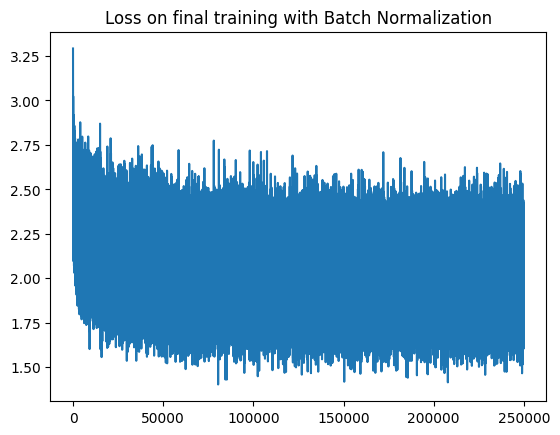

In [19]:
plt.plot(plot_data[:, 0], plot_data[:, 1])
plt.title("Loss on final training with Batch Normalization")
print(f'Loss on the validation set: {get_loss_batch_norm_final(data.x_val, data.y_val, bn_params, hyper_params)}')

## Convolutional layers
Same thing as a linear layer, but they have spatial structure. 
Still Wx + b, but on overlying patches. (TBD expand)

It's a common pattern for DNNs - linear layer (preactivations), normalization layer, non-linearity (logits)

You can use abstractions in Pytorch for linear and normalization layers:
- `torch.nn.Linear`
- `torch.nn.BatchNorm1d`